Cross Exchange funding bot


=== FINAL SUMMARY ===
Initial Balance: $10000.00
Final Balance:   $10000.00
Total Profit:    $0.00
Total Trades:    0
No trades
N/A


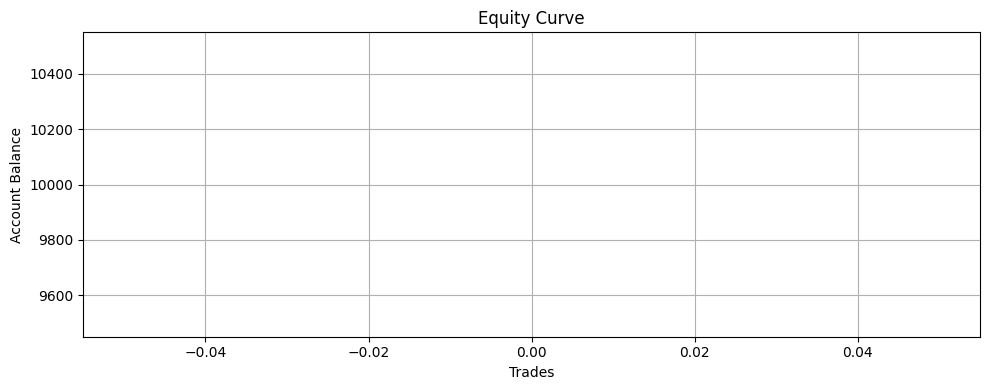


Trades saved to cross_exchange_trades.csv


In [7]:
import pandas as pd
import numpy as np
from decimal import Decimal, ROUND_DOWN
import matplotlib.pyplot as plt

# === Load and preprocess ===
kucoin_df = pd.read_csv("dataset/kucoin_funding_with_futures_prices.csv")
binance_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")

kucoin_df['timestamp'] = pd.to_datetime(kucoin_df['Time'])
binance_df['timestamp'] = pd.to_datetime(binance_df['timestamp'])
kucoin_df['funding_rate'] = pd.to_numeric(kucoin_df['Funding Rate'], errors='coerce')

kucoin_df = kucoin_df.rename(columns={
    'Futures Closing Price': 'kucoin_futures',
    'Spot Closing Price': 'kucoin_spot'
})

# Sort for merge_asof
kucoin_df = kucoin_df.sort_values('timestamp')
binance_df = binance_df.sort_values('timestamp')

# Merge Binance spot to KuCoin timestamps
merged = pd.merge_asof(
    kucoin_df,
    binance_df[['timestamp', 'close_spot']],
    on='timestamp',
    direction='backward'
)

# Drop rows without match
merged = merged.dropna(subset=['close_spot'])

# === Parameters ===
initial_balance = 10000
account_balance = initial_balance
base_funding_rate = 0.0003
min_expected_profit = 0.01
base_holding_hours = 120
funding_interval = 8
risk_per_trade_pct = 0.01
max_trade_size = 0.4
use_taker = False

# Fees
spot_taker_fee = 0.001
futures_taker_fee = 0.0004
spot_maker_fee = 0.001
futures_maker_fee = 0.0002

spot_fee = spot_taker_fee if use_taker else spot_maker_fee
futures_fee = futures_taker_fee if use_taker else futures_maker_fee

# === State ===
position_id = 0
open_positions = []
total_profit = 0
all_pnls = []
trade_log = []

# === Helpers ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_position_size(balance, entry_price):
    risk = balance * risk_per_trade_pct
    size = risk / entry_price
    return round_trade_size(min(size, max_trade_size))

def get_fees(size, spot, futures):
    return size * spot * spot_fee * 2 + size * futures * futures_fee * 2

def calculate_funding(size, rate, price):
    return size * rate * price * (base_holding_hours / funding_interval)

# === Run Bot ===
for i, row in merged.iterrows():
    ts = row['timestamp']
    funding = row['funding_rate']
    kucoin_fut = row['kucoin_futures']
    binance_spot = row['close_spot']

    # Close matured positions
    for pos in open_positions[:]:
        if ts >= pos['target_close_time']:
            hours = (ts - pos['entry_time']).total_seconds() / 3600
            funding_pnl = pos['size'] * pos['funding_rate'] * pos['futures_price'] * (hours / funding_interval)
            if pos['direction'] == 'positive':
                spot_pnl = pos['size'] * (binance_spot - pos['spot_price'])
                fut_pnl = pos['size'] * (pos['futures_price'] - kucoin_fut)
            else:
                spot_pnl = pos['size'] * (pos['spot_price'] - binance_spot)
                fut_pnl = pos['size'] * (kucoin_fut - pos['futures_price'])

            fee = get_fees(pos['size'], pos['spot_price'], kucoin_fut)
            pnl = funding_pnl + spot_pnl + fut_pnl - fee
            total_profit += pnl
            account_balance += pnl
            all_pnls.append(pnl)
            open_positions.remove(pos)

            trade_log.append({
                'entry_time': pos['entry_time'],
                'exit_time': ts,
                'entry_spot': pos['spot_price'],
                'exit_spot': binance_spot,
                'entry_futures': pos['futures_price'],
                'exit_futures': kucoin_fut,
                'funding_rate': pos['funding_rate'],
                'funding_profit': funding_pnl,
                'fees': fee,
                'total_pnl': pnl,
                'hours_held': round(hours, 2),
                'direction': pos['direction']
            })

    # Open new positions
    if ((funding > 0 and funding >= base_funding_rate) or funding < 0):
        size = calculate_position_size(account_balance, kucoin_fut)
        margin_needed = size * kucoin_fut
        if margin_needed <= account_balance * 0.9:
            exp_funding = calculate_funding(size, funding, kucoin_fut)
            fees = get_fees(size, binance_spot, kucoin_fut)
            net = (exp_funding - fees) if funding > 0 else (-exp_funding - fees)

            if net > min_expected_profit:
                open_positions.append({
                    'id': position_id,
                    'entry_time': ts,
                    'target_close_time': ts + pd.Timedelta(hours=base_holding_hours),
                    'spot_price': binance_spot,
                    'futures_price': kucoin_fut,
                    'funding_rate': funding,
                    'size': size,
                    'direction': 'positive' if funding > 0 else 'negative'
                })
                position_id += 1

# === Summary ===
print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance: ${initial_balance:.2f}")
print(f"Final Balance:   ${account_balance:.2f}")
print(f"Total Profit:    ${total_profit:.2f}")
print(f"Total Trades:    {len(all_pnls)}")
print(f"Win Rate:        {sum(p > 0 for p in all_pnls) / len(all_pnls) * 100:.2f}%" if all_pnls else "No trades")
print(f"Avg Profit/Trade:${np.mean(all_pnls):.2f}" if all_pnls else "N/A")

# === Charts ===
equity = [initial_balance]
for p in all_pnls:
    equity.append(equity[-1] + p)

plt.figure(figsize=(10,4))
plt.plot(equity)
plt.title("Equity Curve")
plt.xlabel("Trades")
plt.ylabel("Account Balance")
plt.grid(True)
plt.tight_layout()
plt.show()

trade_df = pd.DataFrame(trade_log)
trade_df.to_csv("cross_exchange_trades.csv", index=False)
print("\nTrades saved to cross_exchange_trades.csv")

Arbitrage opportunities saved to cross_exchange_arb_opportunities.csv


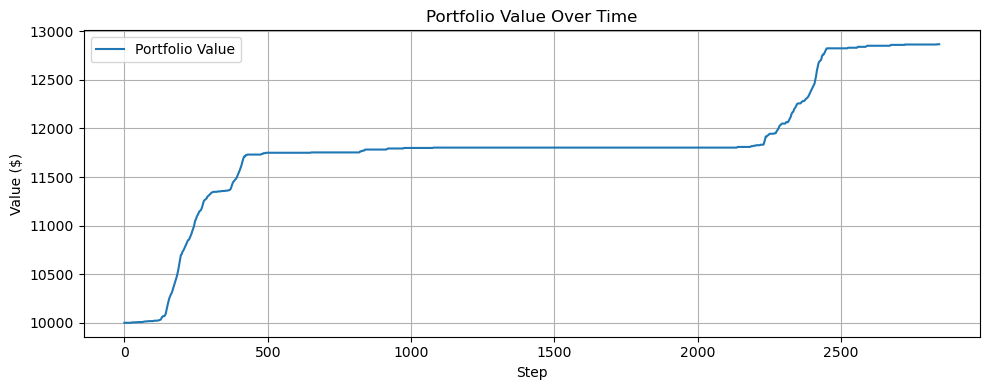

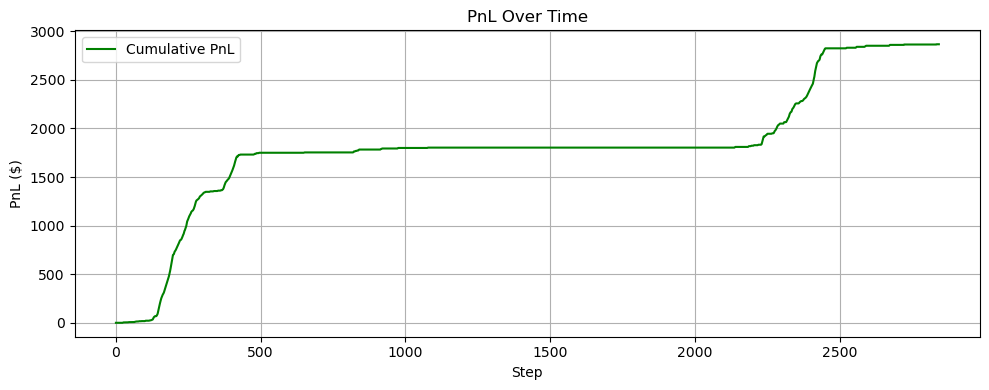

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_DOWN

# === Parameters ===
base_funding_rate = 0.0003
base_trade_size = 0.01
base_holding_hours = 120
funding_interval = 8
min_expected_profit = 0.05
initial_balance = 10000

# Fees
spot_maker_fee = 0.001
futures_maker_fee = 0.0002
spot_taker_fee = 0.001
futures_taker_fee = 0.0004
use_taker = True

# === Helper Functions ===
def get_fees(trade_size, entry_spot, entry_futures):
    spot_fee = spot_taker_fee if use_taker else spot_maker_fee
    futures_fee = futures_taker_fee if use_taker else futures_maker_fee
    return (
        trade_size * entry_spot * spot_fee * 2 +
        trade_size * entry_futures * futures_fee * 2
    )

def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# === Load and Prepare Data ===
binance_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
kucoin_df = pd.read_csv("dataset/kucoin_funding_with_futures_prices.csv")

binance_df['timestamp'] = pd.to_datetime(binance_df['timestamp'])
kucoin_df = kucoin_df.rename(columns={
    'Time': 'timestamp',
    'Funding Rate': 'funding_rate',
    'Spot Closing Price': 'close_spot',
    'Futures Closing Price': 'close_futures'
})
kucoin_df['timestamp'] = pd.to_datetime(kucoin_df['timestamp'])
kucoin_df['funding_rate'] = kucoin_df['funding_rate'].str.replace('%', '').astype(float) / 100
kucoin_df['close_spot'] = pd.to_numeric(kucoin_df['close_spot'], errors='coerce')
kucoin_df['close_futures'] = pd.to_numeric(kucoin_df['close_futures'], errors='coerce')

binance_df['exchange'] = 'binance'
kucoin_df['exchange'] = 'kucoin'
combined_df = pd.concat([binance_df, kucoin_df], ignore_index=True).sort_values('timestamp').reset_index(drop=True)

# === Track Latest Prices and Funding ===
latest_data = {
    'binance': {'spot': None, 'futures': None, 'funding_rate': None},
    'kucoin': {'spot': None, 'futures': None, 'funding_rate': None},
}

arb_opportunities = []
portfolio_value = initial_balance
portfolio_curve = [portfolio_value]
pnl_curve = [0]

for _, row in combined_df.iterrows():
    exch = row['exchange']
    latest_data[exch]['spot'] = row.get('close_spot')
    latest_data[exch]['futures'] = row.get('close_futures')
    latest_data[exch]['funding_rate'] = row.get('funding_rate')

    if all(latest_data[e]['spot'] is not None and
           latest_data[e]['futures'] is not None and
           latest_data[e]['funding_rate'] is not None for e in ['binance', 'kucoin']):

        b = latest_data['binance']
        k = latest_data['kucoin']
        ts = row['timestamp']

        if b['funding_rate'] > base_funding_rate:
            expected_funding = base_trade_size * b['funding_rate'] * k['futures'] * (base_holding_hours / funding_interval)
            fees = get_fees(base_trade_size, b['spot'], k['futures'])
            net_pnl = expected_funding - fees
            if net_pnl > min_expected_profit:
                portfolio_value += net_pnl
                arb_opportunities.append({
                    'timestamp': ts,
                    'trigger': 'binance',
                    'direction': 'Long Spot Binance / Short Futures KuCoin',
                    'funding_rate_binance': b['funding_rate'],
                    'spot_binance': b['spot'],
                    'futures_kucoin': k['futures'],
                    'expected_funding': expected_funding,
                    'fees': fees,
                    'net_expected_profit': net_pnl
                })

        if k['funding_rate'] > base_funding_rate:
            expected_funding = base_trade_size * k['funding_rate'] * b['futures'] * (base_holding_hours / funding_interval)
            fees = get_fees(base_trade_size, k['spot'], b['futures'])
            net_pnl = expected_funding - fees
            if net_pnl > min_expected_profit:
                portfolio_value += net_pnl
                arb_opportunities.append({
                    'timestamp': ts,
                    'trigger': 'kucoin',
                    'direction': 'Long Spot KuCoin / Short Futures Binance',
                    'funding_rate_kucoin': k['funding_rate'],
                    'spot_kucoin': k['spot'],
                    'futures_binance': b['futures'],
                    'expected_funding': expected_funding,
                    'fees': fees,
                    'net_expected_profit': net_pnl
                })

    portfolio_curve.append(portfolio_value)
    pnl_curve.append(portfolio_value - initial_balance)

# Convert to DataFrame and export
arb_df = pd.DataFrame(arb_opportunities)
arb_df.to_csv("cross_exchange_arb_opportunities.csv", index=False)
print("Arbitrage opportunities saved to cross_exchange_arb_opportunities.csv")

# Visualization
plt.figure(figsize=(10, 4))
plt.plot(portfolio_curve, label="Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.xlabel("Step")
plt.ylabel("Value ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(pnl_curve, label="Cumulative PnL", color='green')
plt.title("PnL Over Time")
plt.xlabel("Step")
plt.ylabel("PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Arbitrage opportunities saved to cross_exchange_arb_opportunities.csv


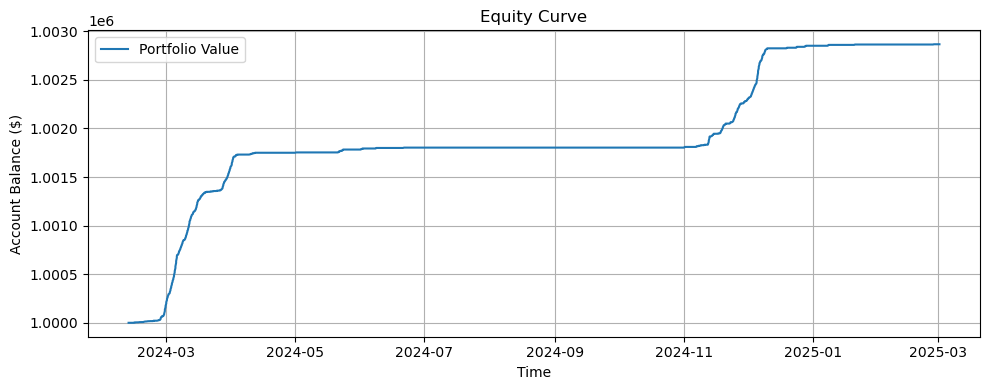

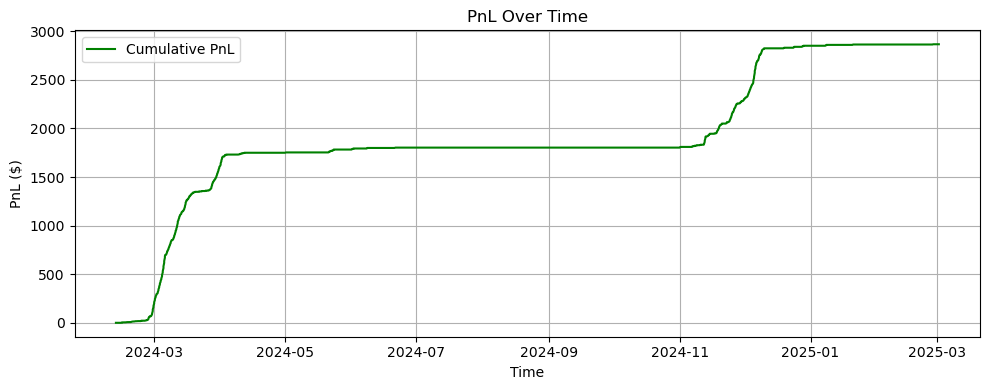


=== FINAL SUMMARY ===
Initial Balance: $1000000.00
Final Balance:   $1002866.70
Total Profit:    $2866.70
Total Trades:    688
Win Rate:        100.00%
Avg Profit/Trade:$4.17


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_DOWN

# === Parameters ===
base_funding_rate = 0.0003
base_trade_size = 0.01
base_holding_hours = 120
funding_interval = 8
min_expected_profit = 0.05
initial_balance = 1000000

# Fees
spot_maker_fee = 0.001
futures_maker_fee = 0.0002
spot_taker_fee = 0.001
futures_taker_fee = 0.0004
use_taker = True

# === Helper Functions ===
def get_fees(trade_size, entry_spot, entry_futures):
    spot_fee = spot_taker_fee if use_taker else spot_maker_fee
    futures_fee = futures_taker_fee if use_taker else futures_maker_fee
    return (
        trade_size * entry_spot * spot_fee * 2 +
        trade_size * entry_futures * futures_fee * 2
    )

def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

# === Load and Prepare Data ===
binance_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
kucoin_df = pd.read_csv("dataset/kucoin_funding_with_futures_prices.csv")

binance_df['timestamp'] = pd.to_datetime(binance_df['timestamp'])
kucoin_df = kucoin_df.rename(columns={
    'Time': 'timestamp',
    'Funding Rate': 'funding_rate',
    'Spot Closing Price': 'close_spot',
    'Futures Closing Price': 'close_futures'
})
kucoin_df['timestamp'] = pd.to_datetime(kucoin_df['timestamp'])
kucoin_df['funding_rate'] = kucoin_df['funding_rate'].str.replace('%', '').astype(float) / 100
kucoin_df['close_spot'] = pd.to_numeric(kucoin_df['close_spot'], errors='coerce')
kucoin_df['close_futures'] = pd.to_numeric(kucoin_df['close_futures'], errors='coerce')

binance_df['exchange'] = 'binance'
kucoin_df['exchange'] = 'kucoin'
combined_df = pd.concat([binance_df, kucoin_df], ignore_index=True).sort_values('timestamp').reset_index(drop=True)

# === Track Latest Prices and Funding ===
latest_data = {
    'binance': {'spot': None, 'futures': None, 'funding_rate': None},
    'kucoin': {'spot': None, 'futures': None, 'funding_rate': None},
}

arb_opportunities = []
portfolio_value = initial_balance
portfolio_curve = []
pnl_curve = []

for _, row in combined_df.iterrows():
    exch = row['exchange']
    latest_data[exch]['spot'] = row.get('close_spot')
    latest_data[exch]['futures'] = row.get('close_futures')
    latest_data[exch]['funding_rate'] = row.get('funding_rate')

    if all(latest_data[e]['spot'] is not None and
           latest_data[e]['futures'] is not None and
           latest_data[e]['funding_rate'] is not None for e in ['binance', 'kucoin']):

        b = latest_data['binance']
        k = latest_data['kucoin']
        ts = row['timestamp']

        if b['funding_rate'] > base_funding_rate:
            expected_funding = base_trade_size * b['funding_rate'] * k['futures'] * (base_holding_hours / funding_interval)
            fees = get_fees(base_trade_size, b['spot'], k['futures'])
            net_pnl = expected_funding - fees
            if net_pnl > min_expected_profit:
                portfolio_value += net_pnl
                arb_opportunities.append({
                    'timestamp': ts,
                    'trigger': 'binance',
                    'direction': 'Long Spot Binance / Short Futures KuCoin',
                    'funding_rate_binance': b['funding_rate'],
                    'spot_binance': b['spot'],
                    'futures_kucoin': k['futures'],
                    'expected_funding': expected_funding,
                    'fees': fees,
                    'net_expected_profit': net_pnl
                })

        if k['funding_rate'] > base_funding_rate:
            expected_funding = base_trade_size * k['funding_rate'] * b['futures'] * (base_holding_hours / funding_interval)
            fees = get_fees(base_trade_size, k['spot'], b['futures'])
            net_pnl = expected_funding - fees
            if net_pnl > min_expected_profit:
                portfolio_value += net_pnl
                arb_opportunities.append({
                    'timestamp': ts,
                    'trigger': 'kucoin',
                    'direction': 'Long Spot KuCoin / Short Futures Binance',
                    'funding_rate_kucoin': k['funding_rate'],
                    'spot_kucoin': k['spot'],
                    'futures_binance': b['futures'],
                    'expected_funding': expected_funding,
                    'fees': fees,
                    'net_expected_profit': net_pnl
                })

    portfolio_curve.append((row['timestamp'], portfolio_value))
    pnl_curve.append((row['timestamp'], portfolio_value - initial_balance))

# Convert to DataFrame and export
arb_df = pd.DataFrame(arb_opportunities)
arb_df.to_csv("cross_exchange_arb_opportunities.csv", index=False)
print("Arbitrage opportunities saved to cross_exchange_arb_opportunities.csv")

# Visualization
# === Extract timestamps and values ===
times_portfolio, values_portfolio = zip(*portfolio_curve)
times_pnl, values_pnl = zip(*pnl_curve)

plt.figure(figsize=(10, 4))
plt.plot(times_portfolio, values_portfolio, label="Portfolio Value")
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Final Summary ===
final_balance = portfolio_value
initial = initial_balance
profit = final_balance - initial
num_trades = len(arb_opportunities)
win_rate = 100.0  # Assumes no losing trades since we only take positive PnL
avg_profit = profit / num_trades if num_trades else 0

plt.figure(figsize=(10, 4))
plt.plot(times_pnl, values_pnl, label="Cumulative PnL", color='green')
plt.title("PnL Over Time")
plt.xlabel("Time")
plt.ylabel("PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance: ${initial:.2f}")
print(f"Final Balance:   ${final_balance:.2f}")
print(f"Total Profit:    ${profit:.2f}")
print(f"Total Trades:    {num_trades}")
print(f"Win Rate:        {win_rate:.2f}%")
print(f"Avg Profit/Trade:${avg_profit:.2f}")

Arbitrage opportunities saved to cross_exchange_arb_opportunities.csv


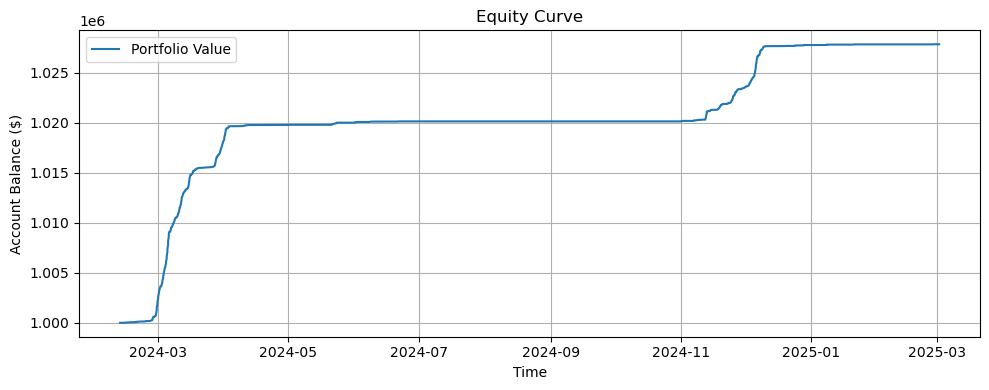

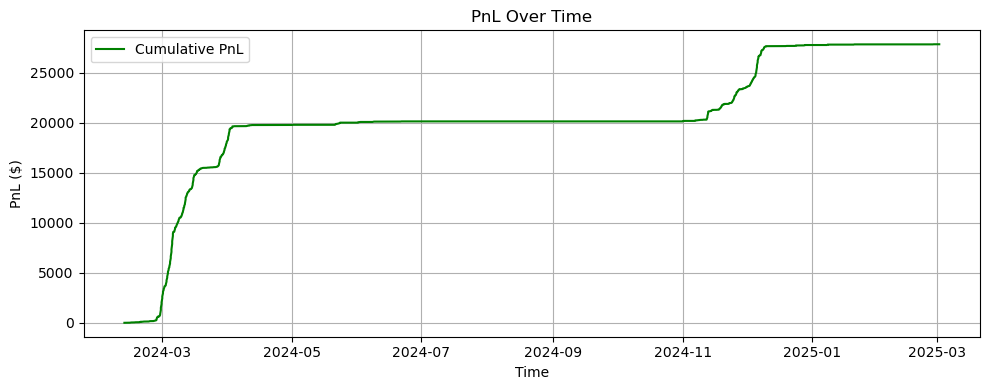

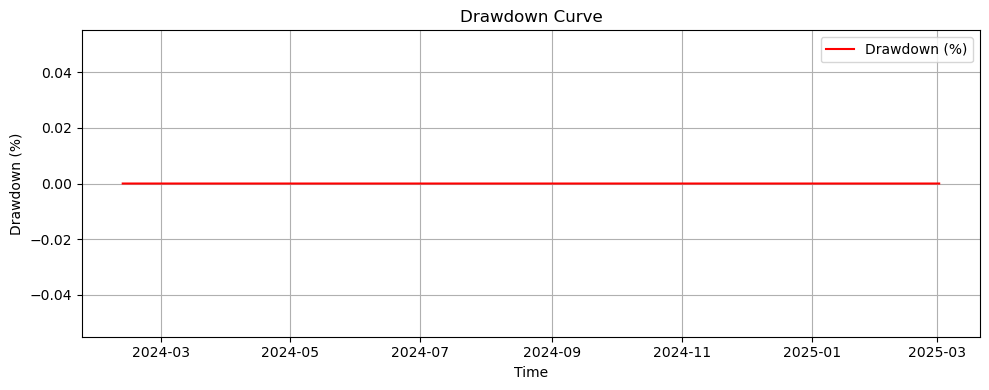


=== FINAL SUMMARY ===
Initial Balance:    $1000000.00
Final Balance:      $1027840.11
Total Profit:       $27840.11
Total Trades:       688
Win Rate:           100.00%
Avg Profit/Trade:   $40.47
Max Drawdown:       $0.00
Max Drawdown (%):   0.00%


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_DOWN

# === Parameters ===
base_funding_rate = 0.0003
base_holding_hours = 120
funding_interval = 8
min_expected_profit = 0.05
initial_balance = 1000000

risk_pct_per_trade = 0.01
use_funding_scaling = True
max_funding_for_scaling = 0.001  # cap funding scaling at 0.1%

# === Exchange Fee Structures ===
def get_cross_exchange_fees(trade_size, spot_exchange, spot_price, futures_exchange, futures_price):
    spot_fee_rate = 0.001 if spot_exchange == 'binance' else 0.001
    futures_fee_rate = 0.0002 if futures_exchange == 'binance' else 0.0002
    settlement_fee = 0.00025 if futures_exchange == 'kucoin' else 0.0

    spot_fees = trade_size * spot_price * spot_fee_rate * 2
    futures_fees = trade_size * futures_price * (futures_fee_rate * 2 + settlement_fee)

    return spot_fees + futures_fees

def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_trade_size(portfolio_value, entry_price, funding_rate=None):
    base_value = portfolio_value * risk_pct_per_trade
    if use_funding_scaling and funding_rate is not None:
        scaling = min(funding_rate / max_funding_for_scaling, 1.0)
        base_value *= scaling
    return round_trade_size(base_value / entry_price)

# === Load and Prepare Data ===
binance_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
kucoin_df = pd.read_csv("dataset/kucoin_funding_with_futures_prices.csv")

binance_df['timestamp'] = pd.to_datetime(binance_df['timestamp'])
kucoin_df = kucoin_df.rename(columns={
    'Time': 'timestamp',
    'Funding Rate': 'funding_rate',
    'Spot Closing Price': 'close_spot',
    'Futures Closing Price': 'close_futures'
})
kucoin_df['timestamp'] = pd.to_datetime(kucoin_df['timestamp'])
kucoin_df['funding_rate'] = kucoin_df['funding_rate'].str.replace('%', '').astype(float) / 100
kucoin_df['close_spot'] = pd.to_numeric(kucoin_df['close_spot'], errors='coerce')
kucoin_df['close_futures'] = pd.to_numeric(kucoin_df['close_futures'], errors='coerce')

binance_df['exchange'] = 'binance'
kucoin_df['exchange'] = 'kucoin'
combined_df = pd.concat([binance_df, kucoin_df], ignore_index=True).sort_values('timestamp').reset_index(drop=True)

latest_data = {
    'binance': {'spot': None, 'futures': None, 'funding_rate': None},
    'kucoin': {'spot': None, 'futures': None, 'funding_rate': None},
}

arb_opportunities = []
portfolio_value = initial_balance
portfolio_curve = []
pnl_curve = []

for _, row in combined_df.iterrows():
    exch = row['exchange']
    latest_data[exch]['spot'] = row.get('close_spot')
    latest_data[exch]['futures'] = row.get('close_futures')
    latest_data[exch]['funding_rate'] = row.get('funding_rate')

    if all(latest_data[e]['spot'] is not None and
           latest_data[e]['futures'] is not None and
           latest_data[e]['funding_rate'] is not None for e in ['binance', 'kucoin']):

        b = latest_data['binance']
        k = latest_data['kucoin']
        ts = row['timestamp']

        # Case 1: Binance funding
        if b['funding_rate'] > base_funding_rate:
            trade_size = calculate_trade_size(portfolio_value, k['futures'], b['funding_rate'])
            expected_funding = trade_size * b['funding_rate'] * k['futures'] * (base_holding_hours / funding_interval)
            fees = get_cross_exchange_fees(trade_size, 'binance', b['spot'], 'kucoin', k['futures'])
            net_pnl = expected_funding - fees
            if net_pnl > min_expected_profit:
                portfolio_value += net_pnl
                arb_opportunities.append({
                    'timestamp': ts,
                    'trigger': 'binance',
                    'direction': 'Long Spot Binance / Short Futures KuCoin',
                    'funding_rate_binance': b['funding_rate'],
                    'spot_binance': b['spot'],
                    'futures_kucoin': k['futures'],
                    'expected_funding': expected_funding,
                    'fees': fees,
                    'net_expected_profit': net_pnl,
                    'trade_size': trade_size
                })

        # Case 2: KuCoin funding
        if k['funding_rate'] > base_funding_rate:
            trade_size = calculate_trade_size(portfolio_value, b['futures'], k['funding_rate'])
            expected_funding = trade_size * k['funding_rate'] * b['futures'] * (base_holding_hours / funding_interval)
            fees = get_cross_exchange_fees(trade_size, 'kucoin', k['spot'], 'binance', b['futures'])
            net_pnl = expected_funding - fees
            if net_pnl > min_expected_profit:
                portfolio_value += net_pnl
                arb_opportunities.append({
                    'timestamp': ts,
                    'trigger': 'kucoin',
                    'direction': 'Long Spot KuCoin / Short Futures Binance',
                    'funding_rate_kucoin': k['funding_rate'],
                    'spot_kucoin': k['spot'],
                    'futures_binance': b['futures'],
                    'expected_funding': expected_funding,
                    'fees': fees,
                    'net_expected_profit': net_pnl,
                    'trade_size': trade_size
                })

    portfolio_curve.append((row['timestamp'], portfolio_value))
    pnl_curve.append((row['timestamp'], portfolio_value - initial_balance))

# === Export Results ===
arb_df = pd.DataFrame(arb_opportunities)
arb_df.to_csv("cross_exchange_arb_opportunities.csv", index=False)
print("Arbitrage opportunities saved to cross_exchange_arb_opportunities.csv")

# === Visualization ===
times_portfolio, values_portfolio = zip(*portfolio_curve)
times_pnl, values_pnl = zip(*pnl_curve)

plt.figure(figsize=(10, 4))
plt.plot(times_portfolio, values_portfolio, label="Portfolio Value")
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(times_pnl, values_pnl, label="Cumulative PnL", color='green')
plt.title("PnL Over Time")
plt.xlabel("Time")
plt.ylabel("PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

portfolio_series = pd.Series(values_portfolio, index=times_portfolio)
rolling_max = portfolio_series.cummax()
drawdown = portfolio_series - rolling_max
drawdown_pct = drawdown / rolling_max

plt.figure(figsize=(10, 4))
plt.plot(drawdown_pct * 100, label="Drawdown (%)", color='red')
plt.title("Drawdown Curve")
plt.xlabel("Time")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Final Summary ===
final_balance = portfolio_value
initial = initial_balance
profit = final_balance - initial
num_trades = len(arb_opportunities)
win_rate = 100.0
avg_profit = profit / num_trades if num_trades else 0
max_drawdown = drawdown.min()
max_drawdown_pct = drawdown_pct.min() * 100

print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance:    ${initial:.2f}")
print(f"Final Balance:      ${final_balance:.2f}")
print(f"Total Profit:       ${profit:.2f}")
print(f"Total Trades:       {num_trades}")
print(f"Win Rate:           {win_rate:.2f}%")
print(f"Avg Profit/Trade:   ${avg_profit:.2f}")
print(f"Max Drawdown:       ${max_drawdown:.2f}")
print(f"Max Drawdown (%):   {max_drawdown_pct:.2f}%")

Arbitrage opportunities saved to cross_exchange_arb_opportunities.csv


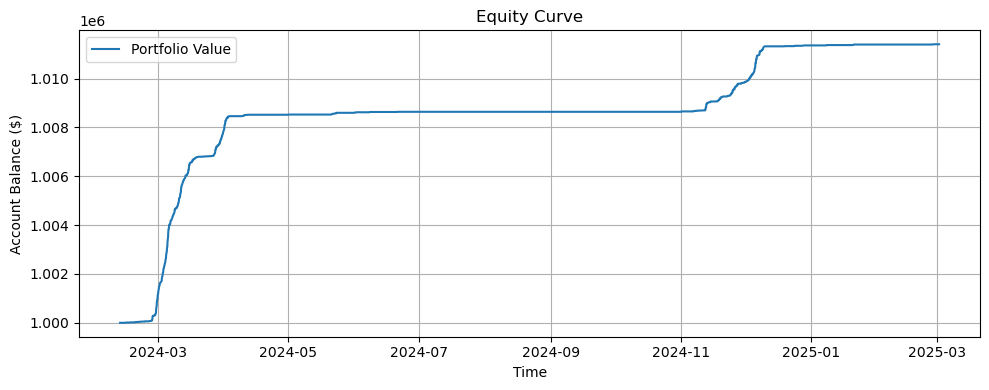

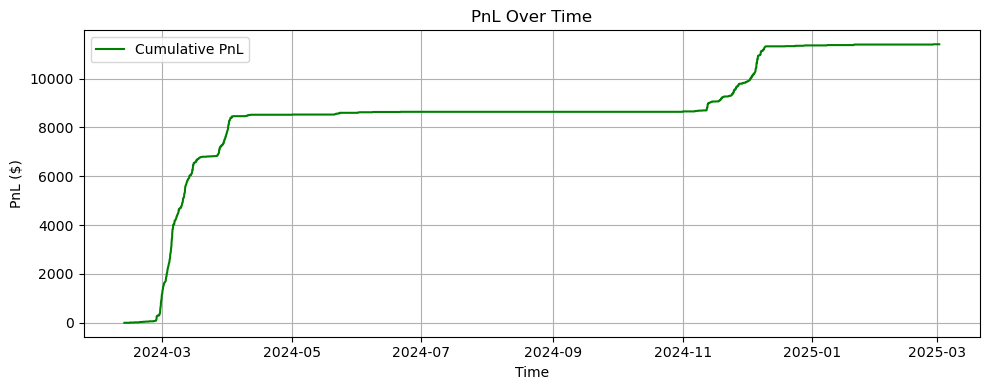

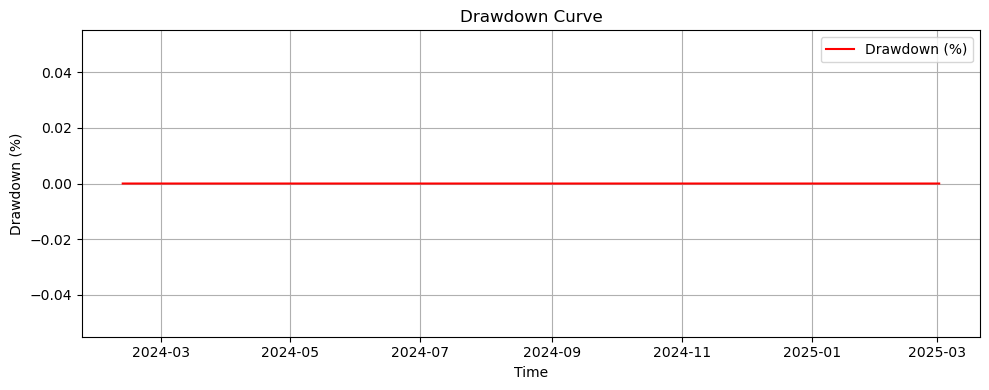


=== FINAL SUMMARY ===
Initial Balance:    $1000000.00
Final Balance:      $1011405.51
Total Profit:       $11405.51
Total Trades:       302
Win Rate:           100.00%
Avg Profit/Trade:   $37.77
Max Drawdown:       $0.00
Max Drawdown (%):   0.00%


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_DOWN

# === Parameters ===
base_funding_rate = 0.0003
base_holding_hours = 120
funding_interval = 8
min_expected_profit = 0.05
initial_balance = 1000000

risk_pct_per_trade = 0.01
use_funding_scaling = True
max_funding_for_scaling = 0.001
valid_binance_hours = {0, 8, 16}
valid_kucoin_hours = {4, 12, 20}

def get_cross_exchange_fees(trade_size, spot_exchange, spot_price, futures_exchange, futures_price):
    spot_fee_rate = 0.001
    futures_fee_rate = 0.0002
    settlement_fee = 0.00025 if futures_exchange == 'kucoin' else 0.0
    spot_fees = trade_size * spot_price * spot_fee_rate * 2
    futures_fees = trade_size * futures_price * (futures_fee_rate * 2 + settlement_fee)
    return spot_fees + futures_fees

def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_trade_size(portfolio_value, entry_price, funding_rate=None):
    base_value = portfolio_value * risk_pct_per_trade
    if use_funding_scaling and funding_rate is not None:
        scaling = min(funding_rate / max_funding_for_scaling, 1.0)
        base_value *= scaling
    return round_trade_size(base_value / entry_price)

def get_nearest_row(ts, df):
    i = df['timestamp'].searchsorted(ts)
    if i == 0:
        return df.iloc[0]
    elif i >= len(df):
        return df.iloc[-1]
    before = df.iloc[i - 1]
    after = df.iloc[i]
    return before if abs(ts - before['timestamp']) < abs(ts - after['timestamp']) else after

# === Load and Prepare Data ===
binance_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
kucoin_df = pd.read_csv("dataset/kucoin_funding_with_futures_prices.csv")

binance_df['timestamp'] = pd.to_datetime(binance_df['timestamp'])
kucoin_df = kucoin_df.rename(columns={
    'Time': 'timestamp',
    'Funding Rate': 'funding_rate',
    'Spot Closing Price': 'close_spot',
    'Futures Closing Price': 'close_futures'
})
kucoin_df['timestamp'] = pd.to_datetime(kucoin_df['timestamp'])
kucoin_df['funding_rate'] = kucoin_df['funding_rate'].str.replace('%', '').astype(float) / 100
kucoin_df['close_spot'] = pd.to_numeric(kucoin_df['close_spot'], errors='coerce')
kucoin_df['close_futures'] = pd.to_numeric(kucoin_df['close_futures'], errors='coerce')

# === Initialize ===
arb_opportunities = []
portfolio_value = initial_balance
portfolio_curve = []
pnl_curve = []

combined_df = pd.concat([binance_df.assign(exchange='binance'), kucoin_df.assign(exchange='kucoin')])
combined_df = combined_df.sort_values('timestamp').reset_index(drop=True)

# === Run Bot ===
for _, row in combined_df.iterrows():
    ts = row['timestamp']
    hour = ts.hour

    if row['exchange'] == 'binance' and hour in valid_binance_hours:
        b = row
        k = get_nearest_row(ts, kucoin_df)
        if pd.notna(b['funding_rate']) and b['funding_rate'] > base_funding_rate:
            trade_size = calculate_trade_size(portfolio_value, k['close_futures'], b['funding_rate'])
            expected_funding = trade_size * b['funding_rate'] * k['close_futures'] * (base_holding_hours / funding_interval)
            fees = get_cross_exchange_fees(trade_size, 'binance', b['close_spot'], 'kucoin', k['close_futures'])
            net_pnl = expected_funding - fees
            if net_pnl > min_expected_profit:
                portfolio_value += net_pnl
                arb_opportunities.append({
                    'timestamp': ts,
                    'trigger': 'binance',
                    'direction': 'Long Spot Binance / Short Futures KuCoin',
                    'funding_rate_binance': b['funding_rate'],
                    'spot_binance': b['close_spot'],
                    'futures_kucoin': k['close_futures'],
                    'expected_funding': expected_funding,
                    'fees': fees,
                    'net_expected_profit': net_pnl,
                    'trade_size': trade_size
                })

    elif row['exchange'] == 'kucoin' and hour in valid_kucoin_hours:
        k = row
        b = get_nearest_row(ts, binance_df)
        if pd.notna(k['funding_rate']) and k['funding_rate'] > base_funding_rate:
            trade_size = calculate_trade_size(portfolio_value, b['close_futures'], k['funding_rate'])
            expected_funding = trade_size * k['funding_rate'] * b['close_futures'] * (base_holding_hours / funding_interval)
            fees = get_cross_exchange_fees(trade_size, 'kucoin', k['close_spot'], 'binance', b['close_futures'])
            net_pnl = expected_funding - fees
            if net_pnl > min_expected_profit:
                portfolio_value += net_pnl
                arb_opportunities.append({
                    'timestamp': ts,
                    'trigger': 'kucoin',
                    'direction': 'Long Spot KuCoin / Short Futures Binance',
                    'funding_rate_kucoin': k['funding_rate'],
                    'spot_kucoin': k['close_spot'],
                    'futures_binance': b['close_futures'],
                    'expected_funding': expected_funding,
                    'fees': fees,
                    'net_expected_profit': net_pnl,
                    'trade_size': trade_size
                })

    portfolio_curve.append((ts, portfolio_value))
    pnl_curve.append((ts, portfolio_value - initial_balance))

# === Export Results ===
arb_df = pd.DataFrame(arb_opportunities)
arb_df.to_csv("cross_exchange_arb_opportunities.csv", index=False)
print("Arbitrage opportunities saved to cross_exchange_arb_opportunities.csv")

# === Visualization ===
times_portfolio, values_portfolio = zip(*portfolio_curve)
times_pnl, values_pnl = zip(*pnl_curve)

plt.figure(figsize=(10, 4))
plt.plot(times_portfolio, values_portfolio, label="Portfolio Value")
plt.title("Equity Curve")
plt.xlabel("Time")
plt.ylabel("Account Balance ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(times_pnl, values_pnl, label="Cumulative PnL", color='green')
plt.title("PnL Over Time")
plt.xlabel("Time")
plt.ylabel("PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

portfolio_series = pd.Series(values_portfolio, index=times_portfolio)
rolling_max = portfolio_series.cummax()
drawdown = portfolio_series - rolling_max
drawdown_pct = drawdown / rolling_max

plt.figure(figsize=(10, 4))
plt.plot(drawdown_pct * 100, label="Drawdown (%)", color='red')
plt.title("Drawdown Curve")
plt.xlabel("Time")
plt.ylabel("Drawdown (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Final Summary ===
final_balance = portfolio_value
initial = initial_balance
profit = final_balance - initial
num_trades = len(arb_opportunities)
win_rate = 100.0
avg_profit = profit / num_trades if num_trades else 0
max_drawdown = drawdown.min()
max_drawdown_pct = drawdown_pct.min() * 100

print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance:    ${initial:.2f}")
print(f"Final Balance:      ${final_balance:.2f}")
print(f"Total Profit:       ${profit:.2f}")
print(f"Total Trades:       {num_trades}")
print(f"Win Rate:           {win_rate:.2f}%")
print(f"Avg Profit/Trade:   ${avg_profit:.2f}")
print(f"Max Drawdown:       ${max_drawdown:.2f}")
print(f"Max Drawdown (%):   {max_drawdown_pct:.2f}%")

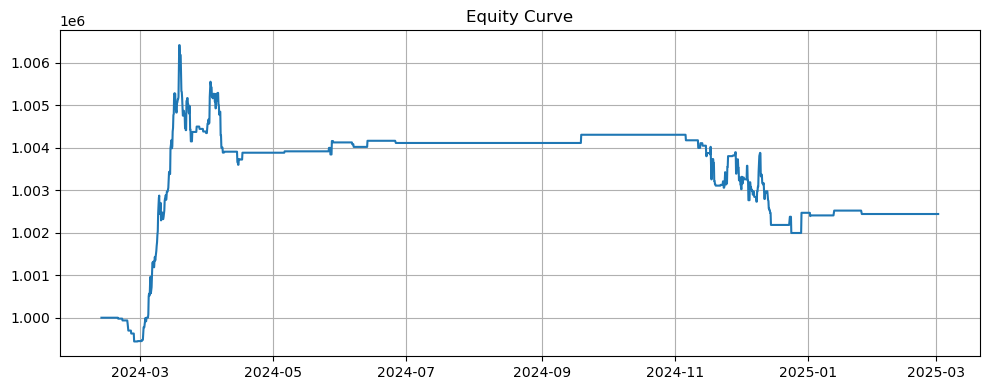

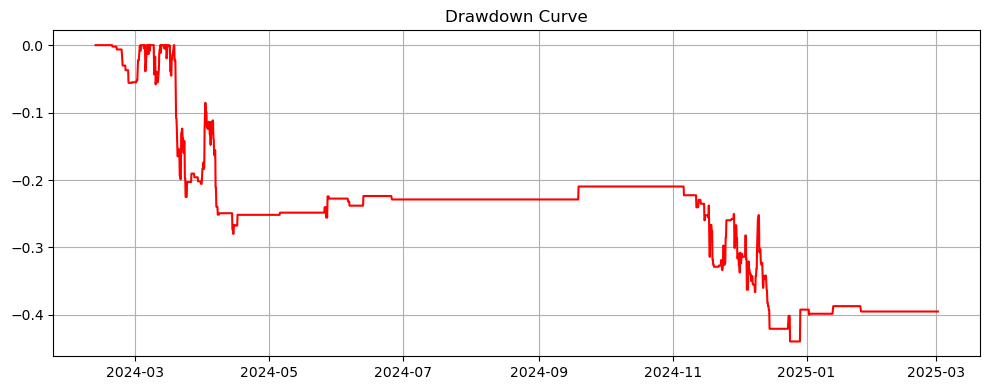


=== FINAL SUMMARY ===
Initial Balance:    $1000000.00
Final Balance:      $1002441.11
Total Profit:       $2441.11
Total Trades:       306
Win Rate:           57.52%
Avg Profit/Trade:   $7.98
Sharpe Ratio:       0.04
Profit Factor:      1.14
Max Drawdown:       $-4421.32
Max Drawdown (%):   -0.44%


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_DOWN

# === Parameters ===
base_funding_rate = 0.0003
min_expected_profit = 0.05
min_trade_value_usd = 20
spot_maker_fee = 0.001
futures_maker_fee = 0.0002
spot_taker_fee = 0.001
futures_taker_fee = 0.0004
use_taker = True
funding_interval = 8
holding_hours = 120
initial_balance = 1000000

account_balance = initial_balance
open_positions = []
position_id = 0
trade_logs = []
portfolio_curve = []
pnl_curve = []

# === Helper Functions ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def calculate_position_size(balance, entry_price):
    raw_size = (balance * 0.01) / entry_price
    return round_trade_size(raw_size)

def get_fees(trade_size, entry_spot, entry_futures, spot_exchange, futures_exchange):
    spot_fee = spot_taker_fee if use_taker else spot_maker_fee
    futures_fee = futures_taker_fee if use_taker else futures_maker_fee
    settlement_fee = 0.00025 if futures_exchange == "kucoin" else 0
    return (
        trade_size * entry_spot * spot_fee * 2 +
        trade_size * entry_futures * (futures_fee * 2 + settlement_fee)
    )

def is_funding_period(ts):
    return ts.hour % funding_interval == 0 and ts.minute == 0

def get_direction(funding_rate):
    return "positive" if funding_rate > 0 else "negative"

# === Load Data ===
binance_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
kucoin_df = pd.read_csv("dataset/kucoin_funding_with_futures_prices.csv")

binance_df['timestamp'] = pd.to_datetime(binance_df['timestamp'])
kucoin_df = kucoin_df.rename(columns={
    'Time': 'timestamp',
    'Funding Rate': 'funding_rate',
    'Spot Closing Price': 'close_spot',
    'Futures Closing Price': 'close_futures'
})
kucoin_df['timestamp'] = pd.to_datetime(kucoin_df['timestamp'])
kucoin_df['funding_rate'] = kucoin_df['funding_rate'].str.replace('%', '').astype(float) / 100
kucoin_df['close_spot'] = pd.to_numeric(kucoin_df['close_spot'], errors='coerce')
kucoin_df['close_futures'] = pd.to_numeric(kucoin_df['close_futures'], errors='coerce')

combined_df = pd.concat([
    binance_df.assign(exchange="binance"),
    kucoin_df.assign(exchange="kucoin")
]).sort_values("timestamp").reset_index(drop=True)

# === Simulation ===
position_last_funding_time = {}

for i, row in combined_df.iterrows():
    ts = row['timestamp']
    exchange = row['exchange']
    spot = row['close_spot']
    futures = row['close_futures']
    funding_rate = row['funding_rate']

    # === Close matured positions ===
    for pos in open_positions[:]:
        if ts >= pos['target_close_time']:
            size = pos['size']
            funding_pnl = pos.get('accumulated_funding', 0)

            if pos['direction'] == "positive":
                spot_pnl = size * (spot - pos['spot'])
                fut_pnl = size * (pos['futures'] - futures)
            else:
                spot_pnl = size * (pos['spot'] - spot)
                fut_pnl = size * (futures - pos['futures'])

            fee = get_fees(size, pos['spot'], pos['futures'], pos['spot_exchange'], pos['futures_exchange'])
            pnl = funding_pnl + spot_pnl + fut_pnl - fee

            account_balance += pnl
            open_positions.remove(pos)

            trade_logs.append({
                'entry_time': pos['entry_time'],
                'exit_time': ts,
                'funding_rate': pos['funding_rate'],
                'funding_profit': funding_pnl,
                'fees': fee,
                'total_pnl': pnl,
                'hours_held': round((ts - pos['entry_time']).total_seconds() / 3600, 2),
                'direction': pos['direction'],
                'trade_size': size,
                'position_type': pos['description']
            })

    # === Accrue funding for active positions ===
    if is_funding_period(ts):
        for pos in open_positions:
            if pos['entry_time'] < ts:
                last_ts = position_last_funding_time.get(pos['id'], pos['entry_time'])
                if ts > last_ts:
                    position_last_funding_time[pos['id']] = ts
                    fr = funding_rate

                    funding_payment = 0
                    if pos['direction'] == 'positive':
                        funding_payment = pos['size'] * abs(fr) * futures if fr > 0 else -pos['size'] * abs(fr) * futures
                    else:
                        funding_payment = pos['size'] * abs(fr) * futures if fr < 0 else -pos['size'] * abs(fr) * futures

                    pos['accumulated_funding'] = pos.get('accumulated_funding', 0) + funding_payment

    # === Open new positions ===
    if abs(funding_rate) >= base_funding_rate:
        size = calculate_position_size(account_balance, futures)
        usd_value = size * futures
        if usd_value < min_trade_value_usd:
            continue

        net_expected, fee_estimate = 0, get_fees(size, spot, futures, exchange, "kucoin" if exchange == "binance" else "binance")
        expected_funding = size * abs(funding_rate) * futures * (holding_hours / funding_interval)
        net_expected = expected_funding - fee_estimate

        if net_expected > min_expected_profit:
            pos = {
                'id': position_id,
                'entry_time': ts,
                'target_close_time': ts + pd.Timedelta(hours=holding_hours),
                'spot': spot,
                'futures': futures,
                'funding_rate': funding_rate,
                'size': size,
                'spot_exchange': exchange,
                'futures_exchange': "kucoin" if exchange == "binance" else "binance",
                'direction': get_direction(funding_rate),
                'description': f"Long Spot {exchange} / Short Futures {'kucoin' if exchange == 'binance' else 'binance'}" if funding_rate > 0 else f"Short Spot {exchange} / Long Futures {'kucoin' if exchange == 'binance' else 'binance'}",
                'accumulated_funding': 0
            }
            open_positions.append(pos)
            position_id += 1

    portfolio_curve.append((ts, account_balance))
    pnl_curve.append((ts, account_balance - initial_balance))

# === Results ===
trade_df = pd.DataFrame(trade_logs)
portfolio_series = pd.Series([p[1] for p in portfolio_curve], index=[p[0] for p in portfolio_curve])
rolling_max = portfolio_series.cummax()
drawdown = portfolio_series - rolling_max
drawdown_pct = drawdown / rolling_max

# === Charts ===
plt.figure(figsize=(10, 4))
plt.plot(portfolio_series, label='Equity Curve')
plt.title("Equity Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(drawdown_pct * 100, label='Drawdown %', color='red')
plt.title("Drawdown Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Summary ===
total_profit = account_balance - initial_balance
win_rate = sum(trade_df['total_pnl'] > 0) / len(trade_df) if len(trade_df) else 0
avg_pnl = trade_df['total_pnl'].mean() if len(trade_df) else 0
sharpe = trade_df['total_pnl'].mean() / trade_df['total_pnl'].std() if trade_df['total_pnl'].std() > 0 else 0
gross_profit = trade_df.loc[trade_df['total_pnl'] > 0, 'total_pnl'].sum()
gross_loss = abs(trade_df.loc[trade_df['total_pnl'] < 0, 'total_pnl'].sum())
profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance:    ${initial_balance:.2f}")
print(f"Final Balance:      ${account_balance:.2f}")
print(f"Total Profit:       ${total_profit:.2f}")
print(f"Total Trades:       {len(trade_df)}")
print(f"Win Rate:           {win_rate*100:.2f}%")
print(f"Avg Profit/Trade:   ${avg_pnl:.2f}")
print(f"Sharpe Ratio:       {sharpe:.2f}")
print(f"Profit Factor:      {profit_factor:.2f}")
print(f"Max Drawdown:       ${drawdown.min():.2f}")
print(f"Max Drawdown (%):   {drawdown_pct.min()*100:.2f}%")


=== FINAL SUMMARY ===
Initial Balance:    $1000000.00
Final Balance:      $1033281.53
Total Profit:       $33281.53
Total Trades:       694
Win Rate:           69.31%
Avg Profit/Trade:   $47.96
Sharpe Ratio:       0.24
Profit Factor:      1.98
Max Drawdown:       $-4031.42
Max Drawdown (%):   -0.39%


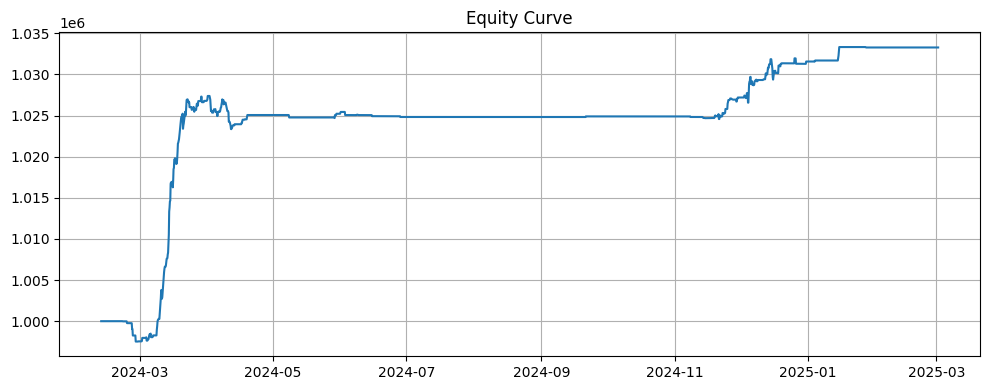

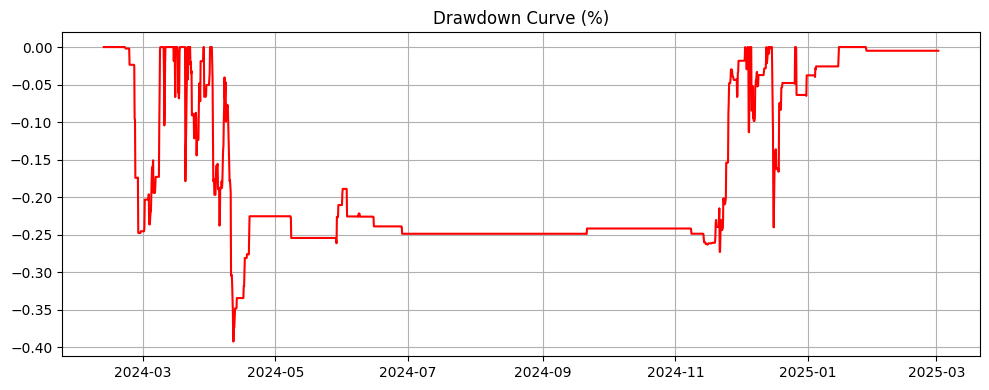

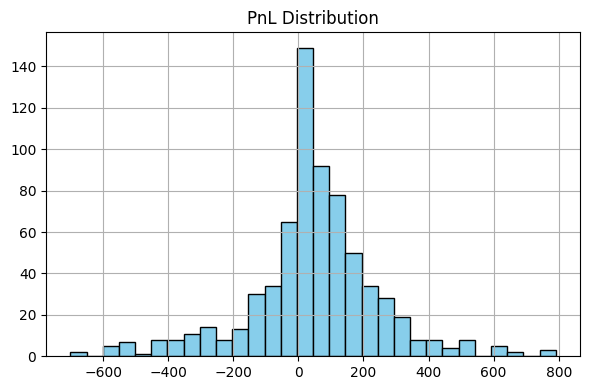

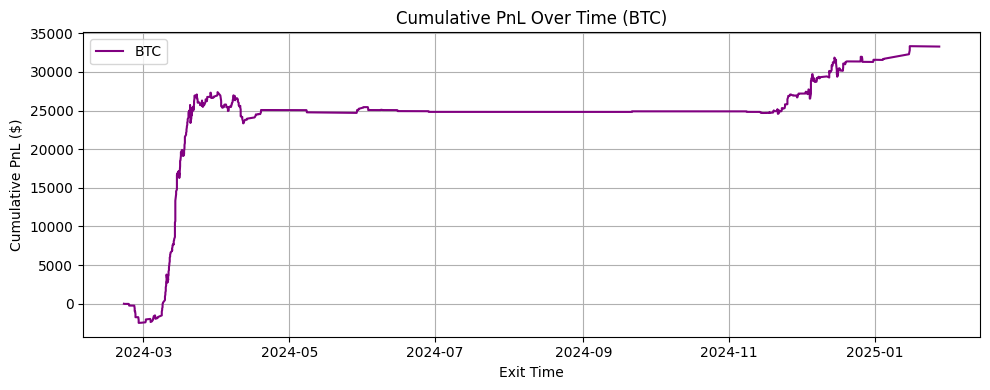

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_DOWN

# === Parameters ===
initial_balance = 1000000
account_balance = initial_balance
risk_pct_per_trade = 0.01
base_funding_rate = 0.0003
min_expected_profit = 0.05
min_trade_value_usd = 20
funding_interval = 8  # hours

# Fees
spot_maker_fee = 0.001
futures_maker_fee = 0.0002
spot_taker_fee = 0.001
futures_taker_fee = 0.0004
kucoin_settlement_fee = 0.00025
use_taker = True

# === Load Data ===
binance_df = pd.read_csv("dataset/binance_btcusdt_data_2025-03-20.csv")
kucoin_df = pd.read_csv("dataset/kucoin_funding_with_futures_prices.csv")

binance_df['timestamp'] = pd.to_datetime(binance_df['timestamp'])
kucoin_df = kucoin_df.rename(columns={
    'Time': 'timestamp',
    'Funding Rate': 'funding_rate',
    'Spot Closing Price': 'close_spot',
    'Futures Closing Price': 'close_futures'
})
kucoin_df['timestamp'] = pd.to_datetime(kucoin_df['timestamp'])
kucoin_df['funding_rate'] = kucoin_df['funding_rate'].str.replace('%', '').astype(float) / 100
kucoin_df['close_spot'] = pd.to_numeric(kucoin_df['close_spot'], errors='coerce')
kucoin_df['close_futures'] = pd.to_numeric(kucoin_df['close_futures'], errors='coerce')

binance_df['exchange'] = 'binance'
kucoin_df['exchange'] = 'kucoin'
combined_df = pd.concat([binance_df, kucoin_df], ignore_index=True).sort_values('timestamp').reset_index(drop=True)

# === Helper Functions ===
def round_trade_size(size):
    return float(Decimal(str(size)).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

def is_funding_time(ts):
    return ts.hour % funding_interval == 0 and ts.minute == 0

def get_dynamic_holding_hours(funding):
    if funding >= 0.0005:
        return 248
    elif funding >= 0.00025:
        return 168
    elif funding >= 0.0001:
        return 96
    else:
        return 0

def get_fees(size, spot_price, futures_price, spot_ex, fut_ex):
    spot_fee = spot_taker_fee if use_taker else spot_maker_fee
    futures_fee = futures_taker_fee if use_taker else futures_maker_fee
    settlement = kucoin_settlement_fee if fut_ex == 'kucoin' else 0.0

    spot_fees = size * spot_price * spot_fee * 2
    futures_fees = size * futures_price * (futures_fee * 2 + settlement)
    return spot_fees + futures_fees

def calculate_trade_size(balance, entry_price):
    return round_trade_size((balance * risk_pct_per_trade) / entry_price)

# === Simulation ===
open_positions = []
position_id = 0
portfolio_curve = []
pnl_curve = []
trade_logs = []
position_funding_times = {}
account_balance = initial_balance

latest = {'binance': {}, 'kucoin': {}}

for i, row in combined_df.iterrows():
    ts = row['timestamp']
    ex = row['exchange']
    latest[ex]['spot'] = row['close_spot']
    latest[ex]['futures'] = row['close_futures']
    latest[ex]['funding'] = row['funding_rate']

    if all(k in latest['binance'] and k in latest['kucoin'] for k in ['spot', 'futures', 'funding']):
        b = latest['binance']
        k = latest['kucoin']

        # === Close expired positions ===
        for pos in open_positions[:]:
            if ts >= pos['close_time']:
                spot = b['spot'] if pos['spot_ex'] == 'binance' else k['spot']
                futures = b['futures'] if pos['fut_ex'] == 'binance' else k['futures']
                funding_pnl = pos.get('funding_pnl', 0)

                if pos['direction'] == 'positive':
                    spot_pnl = pos['size'] * (spot - pos['spot'])
                    fut_pnl = pos['size'] * (pos['futures'] - futures)
                else:
                    spot_pnl = pos['size'] * (pos['spot'] - spot)
                    fut_pnl = pos['size'] * (futures - pos['futures'])

                fees = get_fees(pos['size'], pos['spot'], pos['futures'], pos['spot_ex'], pos['fut_ex'])
                pnl = spot_pnl + fut_pnl + funding_pnl - fees
                account_balance += pnl

                trade_logs.append({
                    'entry': pos['entry'],
                    'exit': ts,
                    'direction': pos['description'],
                    'size': pos['size'],
                    'funding_pnl': funding_pnl,
                    'fees': fees,
                    'spot_pnl': spot_pnl,
                    'fut_pnl': fut_pnl,
                    'total_pnl': pnl,
                    'hours_held': round((ts - pos['entry']).total_seconds() / 3600, 2)
                })
                open_positions.remove(pos)

        # === Accrue funding ===
        if is_funding_time(ts):
            for pos in open_positions:
                last = position_funding_times.get(pos['id'], pos['entry'])
                if ts > last:
                    funding = b['funding'] if pos['fut_ex'] == 'binance' else k['funding']
                    price = b['futures'] if pos['fut_ex'] == 'binance' else k['futures']

                    if pos['direction'] == 'positive':
                        delta = pos['size'] * price * (funding if funding > 0 else -funding)
                        funding_pnl = delta if funding > 0 else -delta
                    else:
                        delta = pos['size'] * price * (funding if funding < 0 else -funding)
                        funding_pnl = delta if funding < 0 else -delta

                    pos['funding_pnl'] = pos.get('funding_pnl', 0) + funding_pnl
                    position_funding_times[pos['id']] = ts

        # === Open new positions ===
        for ex_name, funding, spot_price, fut_price in [
            ('binance', b['funding'], b['spot'], k['futures']),
            ('kucoin', k['funding'], k['spot'], b['futures'])
        ]:
            if abs(funding) < base_funding_rate:
                continue

            direction = 'positive' if funding > 0 else 'negative'
            holding = get_dynamic_holding_hours(abs(funding))
            if holding == 0:
                continue

            size = calculate_trade_size(account_balance, fut_price)
            if size * fut_price < min_trade_value_usd:
                continue

            fees = get_fees(size, spot_price, fut_price, ex_name, 'kucoin' if ex_name == 'binance' else 'binance')
            exp_funding = size * abs(funding) * fut_price * (holding / funding_interval)
            net_expected = exp_funding - fees
            if net_expected < min_expected_profit:
                continue

            open_positions.append({
                'id': position_id,
                'entry': ts,
                'close_time': ts + pd.Timedelta(hours=holding),
                'size': size,
                'spot': spot_price,
                'futures': fut_price,
                'spot_ex': ex_name,
                'fut_ex': 'kucoin' if ex_name == 'binance' else 'binance',
                'direction': direction,
                'description': f"{ex_name.upper()} Spot / {'Kucoin' if ex_name == 'binance' else 'Binance'} Futures",
                'funding_pnl': 0
            })
            position_funding_times[position_id] = ts
            position_id += 1

    portfolio_curve.append((ts, account_balance))
    pnl_curve.append((ts, account_balance - initial_balance))

# === Summary ===
df = pd.DataFrame(trade_logs)
portfolio_series = pd.Series([x[1] for x in portfolio_curve], index=[x[0] for x in portfolio_curve])
rolling_max = portfolio_series.cummax()
drawdown = portfolio_series - rolling_max
drawdown_pct = drawdown / rolling_max

print("\n=== FINAL SUMMARY ===")
print(f"Initial Balance:    ${initial_balance:.2f}")
print(f"Final Balance:      ${account_balance:.2f}")
print(f"Total Profit:       ${account_balance - initial_balance:.2f}")
print(f"Total Trades:       {len(df)}")
print(f"Win Rate:           {100 * (df['total_pnl'] > 0).mean():.2f}%" if not df.empty else "N/A")
print(f"Avg Profit/Trade:   ${df['total_pnl'].mean():.2f}" if not df.empty else "N/A")
print(f"Sharpe Ratio:       {df['total_pnl'].mean() / df['total_pnl'].std():.2f}" if df['total_pnl'].std() > 0 else "0")
print(f"Profit Factor:      {df[df['total_pnl'] > 0]['total_pnl'].sum() / abs(df[df['total_pnl'] < 0]['total_pnl'].sum()) if not df[df['total_pnl'] < 0].empty else float('inf'):.2f}")
print(f"Max Drawdown:       ${drawdown.min():.2f}")
print(f"Max Drawdown (%):   {100 * drawdown_pct.min():.2f}%")

# === Charts ===
plt.figure(figsize=(10, 4))
plt.plot(portfolio_series)
plt.title("Equity Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(drawdown_pct * 100, color='red')
plt.title("Drawdown Curve (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(df['total_pnl'], bins=30, color='skyblue', edgecolor='black')
plt.title("PnL Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Cumulative PnL Over Time ===
df['cumulative_pnl'] = df['total_pnl'].cumsum()

plt.figure(figsize=(10, 4))
plt.plot(df['exit'], df['cumulative_pnl'], label='BTC', color='purple')
plt.title("Cumulative PnL Over Time (BTC)")
plt.xlabel("Exit Time")
plt.ylabel("Cumulative PnL ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()